In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
import glob
import librosa
import numpy as np
import librosa.display
import moviepy.editor as mp
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale
from Audio_Sentiment_Analysis.utils.Configuration import Configuration

In [2]:
AUDIO_DIR = f"{os.path.abspath('./../../')}/eNTERFACE05_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/enterface05_data/config.json"
config = Configuration.load_json(CONFIG_FILE)

In [3]:
def spikes(data):
    if len(data.shape) != 1:
        data = np.concatenate(data)
    mean = np.mean(data)
    std = np.std(data)
    threshold = mean + std * 2 / 100
    num_spikes = 0
    for value in data:
        if value >= threshold:
            num_spikes += 1
    
    return num_spikes

In [4]:
def extract_features(audio_file, subject, gender, emotion, analysis=False):
    emotion_number = {
        'anger': 0,
        'disgust': 1,
        'fear': 2,
        'happiness': 3,
        'sadness': 4,
        'surprise': 5
    }

    # file = audio_file.split(".")[-2].split("\\")[-1]
    file = audio_file.split(".")[-2].split("/")[-1]

    y, sr = librosa.load(audio_file, res_type='kaiser_fast')

    mfcc = librosa.feature.mfcc(y, sr=sr)
    mel_spect = librosa.feature.melspectrogram(y, sr=sr, n_mels=config.n_mels)
    rms = librosa.feature.rms(y)
    chroma_stft = librosa.feature.chroma_stft(y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y, sr=sr)
    spec_cont = librosa.feature.spectral_contrast(y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y, sr=sr)
    spec_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    if analysis:
        return [file, subject, gender, emotion, y, sr, mel_spect, mfcc, chroma_stft, rms, spec_cent,\
            spec_cont, spec_bw, spec_rolloff, zcr]

    features_str = f'{file} {subject} {gender} {emotion} {emotion_number[emotion]}\
        {spikes(mel_spect)} {np.mean(mel_spect)} {np.min(mel_spect)} {np.max(mel_spect)} {np.var(mel_spect)} {np.std(mel_spect)} {np.sum(mel_spect)}\
        {spikes(chroma_stft)} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.std(chroma_stft)} {np.sum(chroma_stft)}\
        {spikes(rms)} {np.mean(rms)} {np.max(rms)} {np.var(rms)} {np.std(rms)} {np.sum(rms)}\
        {spikes(spec_cent)} {np.mean(spec_cent)} {np.min(spec_cent)} {np.max(spec_cent)} {np.var(spec_cent)} {np.std(spec_cent)} {np.sum(spec_cent)}\
        {spikes(spec_bw)} {np.mean(spec_bw)} {np.min(spec_bw)} {np.max(spec_bw)} {np.var(spec_bw)} {np.std(spec_bw)} {np.sum(spec_bw)}\
        {spikes(spec_rolloff)} {np.mean(spec_rolloff)} {np.min(spec_rolloff)} {np.max(spec_rolloff)} {np.var(spec_rolloff)} {np.std(spec_rolloff)} {np.sum(spec_rolloff)}\
        {spikes(spec_cont)} {np.mean(spec_cont)} {np.min(spec_cont)} {np.max(spec_cont)} {np.var(spec_cont)} {np.std(spec_cont)} {np.sum(spec_cont)}\
        {spikes(zcr)} {np.mean(zcr)} {np.min(zcr)} {np.max(zcr)} {np.var(zcr)} {np.std(zcr)} {np.sum(zcr)}'

    for e in mfcc:
        features_str += f' {spikes(e)} {np.mean(e)} {np.min(e)} {np.max(e)} {np.var(e)} {np.std(e)} {np.sum(e)}'

    return features_str.split()

In [4]:
headers = ['File', 'Subject', 'Gender', 'Emotion', 'Emotion_Id',\
    'spikes_mel_spect', 'mean_mel_spect', 'min_mel_spect', 'max_mel_spect', 'var_mel_spect', 'std_mel_spect', 'sum_mel_spect',\
    'spikes_chroma_stft', 'mean_chroma_stft', 'var_chroma_stft', 'std_chroma_stft', 'sum_chroma_stft',\
    'spikes_rms', 'mean_rms', 'max_rms', 'var_rms', 'std_rms', 'sum_rms',\
    'spikes_spec_cent', 'mean_spec_cent', 'min_spec_cent', 'max_spec_cent', 'var_spec_cent', 'std_spec_cent', 'sum_spec_cent',\
    'spikes_spec_bw', 'mean_spec_bw', 'min_spec_bw', 'max_spec_bw', 'var_spec_bw', 'std_spec_bw', 'sum_spec_bw',\
    'spikes_spec_rolloff', 'mean_spec_rolloff', 'min_spec_rolloff', 'max_spec_rolloff', 'var_spec_rolloff', 'std_spec_rolloff', 'sum_spec_rolloff',\
    'spikes_spec_cont', 'mean_spec_cont', 'min_spec_cont', 'max_spec_cont', 'var_spec_cont', 'std_spec_cont', 'sum_spec_cont',\
    'spikes_zcr', 'mean_zcr', 'min_zcr', 'max_zcr', 'var_zcr', 'std_zcr', 'sum_zcr']
for i in range(1, 21):
    headers.extend([f'spikes_mfcc{i}', f'mean_mfcc{i}', f'min_mfcc{i}', f'max_mfcc{i}', f'var_mfcc{i}', f'std_mfcc{i}', f'sum_mfcc{i}'])
print(f"Number of Features: {len(headers) - 5}")

Number of Features: 193


In [6]:
def process_data(audio_dir, headers, proc_feat_dataset):
    # Create a CSV for storing all processed features and write the header
    file = open(proc_feat_dataset, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(headers)

    print("Processing audio files from all subjects:")
    for file_path in tqdm(glob.glob(audio_dir+'/*/*/*/*.avi')):
        # labels =  file_path.split('\\')
        labels =  file_path.split('/')
        subject = labels[-4].split('_')[1]
        gender = labels[-4].split('_')[2]
        emotion = labels[-3]

        audio_file_path = file_path[:-3] + 'wav'
        # convert file type to wav
        if not os.path.isfile(audio_file_path):
            audio_clip = mp.VideoFileClip(file_path)
            audio_clip.audio.write_audiofile(audio_file_path)
        file_path = audio_file_path

        processed_data = extract_features(file_path, subject, gender, emotion)
        writer.writerow(processed_data)

In [31]:
process_data(AUDIO_DIR, headers, EXTRACTED_FEATURES_FILE)

Processing audio files from all subjects:


100%|██████████| 1260/1260 [01:41<00:00, 12.41it/s]


# Feature Analysis

In [6]:
columns = ['File', 'Subject', 'Gender', 'Emotion', 'signal', 'sample_rate', 'mel_spec', 'mfcc', 'chroma_stft', 'rms', 'spec_cent', 'spec_cont', 'spec_bw', 'spec_rolloff', 'zcr']
df = pd.DataFrame(columns=columns)

for file_path in tqdm(glob.glob(AUDIO_DIR+"/subject_*_[a-z]/*/*/*.wav")):
    # labels =  file_path.split('\\')
    labels =  file_path.split('/')
    subject = int(labels[-4].split('_')[1])
    gender = labels[-4].split('_')[2]
    emotion = labels[-3]

    features = extract_features(file_path, subject, gender, emotion, analysis=True)

    df = df.append(pd.DataFrame(features, index=columns).transpose(), ignore_index=True)

df = df.sort_values(['Subject', 'Emotion'], ascending = (True, True))
df = df.set_index('Subject')
df

100%|██████████| 1260/1260 [03:17<00:00,  6.39it/s]


,File,Gender,Emotion,signal,sample_rate,mel_spec,mfcc,chroma_stft,rms,spec_cent,spec_cont,spec_bw,spec_rolloff,zcr
Subject,,,,,,,,,,,,,,
1,s1_an_1,m,anger,"[0.00035997134, -0.0010580126, -0.002465626, -...",22050,"[[0.002001118, 0.0017819228, 0.001719562, 0.00...","[[-429.37125, -428.35626, -430.707, -424.46725...","[[0.52323896, 0.9551258, 0.65299, 0.5713825, 0...","[[0.00292947, 0.0027857684, 0.002886968, 0.002...","[[2384.27082998268, 2214.5540898306135, 2182.2...","[[25.799500683313457, 11.802808267515715, 17.1...","[[2508.8527015113987, 2445.376495373341, 2444....","[[5749.365234375, 5717.0654296875, 5695.532226...","[[0.05859375, 0.08935546875, 0.11572265625, 0...."
1,s1_an_2,m,anger,"[-0.00027841155, 0.00018993257, 0.00018788749,...",22050,"[[0.0024354758, 0.00069461006, 0.00033464364, ...","[[-446.32922, -440.68665, -433.72247, -428.577...","[[0.40890247, 0.1631425, 0.13072109, 0.1432946...","[[0.0024410393, 0.0023770179, 0.002598294, 0.0...","[[2587.5573247892034, 2314.7983910435664, 2182...","[[15.270894143882153, 11.395311233370052, 14.8...","[[2499.629839384475, 2461.804360468753, 2418.8...","[[5824.7314453125, 5727.83203125, 5630.9326171...","[[0.05517578125, 0.07958984375, 0.1044921875, ..."
1,s1_an_5,m,anger,"[0.00071568514, 0.0011181713, 0.0004959308, 0....",22050,"[[0.00064072805, 0.00046260562, 0.00048341657,...","[[-415.10132, -410.86313, -411.8919, -414.0132...","[[0.9110132, 0.33617517, 0.5366259, 0.48578024...","[[0.0027495404, 0.0026907374, 0.0025483014, 0....","[[2233.553470696531, 2227.2811099415853, 2336....","[[16.34120148399178, 16.17802979696181, 16.758...","[[2371.353275439757, 2352.7387710159537, 2383....","[[5652.4658203125, 5620.166015625, 5727.832031...","[[0.05712890625, 0.11181640625, 0.14697265625,..."
1,s1_an_4,m,anger,"[0.0052672788, 0.007731445, 0.0069936556, 0.00...",22050,"[[0.002444172, 0.003221243, 0.002198903, 0.001...","[[-418.07758, -419.15588, -418.8444, -416.2291...","[[0.5234604, 0.64830875, 0.3885145, 0.26792338...","[[0.0032232222, 0.0031892122, 0.003136706, 0.0...","[[2069.366877548067, 2052.903341285958, 2171.3...","[[13.034920592981253, 9.055023211591367, 13.13...","[[2577.9189292955816, 2480.76625200809, 2384.5...","[[5684.765625, 5706.298828125, 5706.298828125,...","[[0.0634765625, 0.09326171875, 0.11572265625, ..."
1,s1_an_3,m,anger,"[-0.004105932, -0.005565478, -0.0050745644, -0...",22050,"[[0.008966011, 0.0026458546, 0.0009074437, 0.0...","[[-433.5722, -433.8605, -435.92566, -434.57443...","[[0.31093308, 0.34250224, 0.39898673, 0.283956...","[[0.003229968, 0.0036074547, 0.0036071395, 0.0...","[[2068.300995965922, 2131.366293101691, 1962.8...","[[15.739158906605844, 10.301224006177943, 16.5...","[[2492.7710109716463, 2480.972265431229, 2395....","[[5609.3994140625, 5706.298828125, 5458.666992...","[[0.0537109375, 0.07568359375, 0.0966796875, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,s42_su_1,m,surprise,"[-0.0001498006, 0.0003146613, 0.0004020443, -7...",22050,"[[0.011193215, 0.006772931, 0.001384477, 0.000...","[[-590.17035, -582.1931, -577.7394, -582.8009,...","[[0.5749535, 0.7422322, 0.7142719, 0.628281, 0...","[[0.00080113544, 0.000801972, 0.0006590202, 0....","[[2721.0160655070686, 2966.0677546240267, 3184...","[[18.414205147442477, 14.765872795220208, 10.9...","[[3000.9643087592012, 3011.4863798466713, 2988...","[[6707.5927734375, 6955.224609375, 7073.657226...","[[0.05419921875, 0.0927734375, 0.13330078125, ..."
42,s42_su_2,m,surprise,"[-0.00018786022, -0.00028358848, 7.9695295e-05...",22050,"[[0.002862056, 0.0017321848, 0.00072638626, 0....","[[-573.54254, -573.71686, -575.0657, -572.1788...","[[0.90374917, 0.8484845, 0.65182227, 0.7383683...","[[0.00048400616, 0.0004823023, 0.0004851635, 0...","[[3041.9635305496568, 3297.664565620426, 3433....","[[12.172921126101228, 12.845739828814676, 15.5...","[[3012.907157899424, 3026.41782858956, 2954.64...","[[7073.6572265625, 7288.9892578125, 7245.92285...","[[0.09033203125, 0.140625, 0.1704101

### Gender Distribution of Subjects

In [7]:
subjs_df = df.groupby(['Subject']).first()
print(f"Number of Subjects: {len(subjs_df)}")
print(f"Number of Male Subjects: {len(subjs_df.loc[subjs_df['Gender'] == 'm'])}")
print(f"Number of Female Subjects: {len(subjs_df.loc[subjs_df['Gender'] == 'f'])}")

Number of Subjects: 42
Number of Male Subjects: 35
Number of Female Subjects: 7


In [8]:
def signal_analysis(axs, i, emotion, signal, sample_rate):
    print(f'\tSample rate = {sample_rate}')
    print(f'\tSignal mean = {np.mean(signal):.5f}')
    print(f'\tSignal minimum = {np.std(signal):.5f}')
    print(f'\tSignal maximum = {np.std(signal):.5f}')
    print(f'\tSignal standard deviation = {np.std(signal):.5f}')
    print(f'\tSignal variance = {np.std(signal):.5f}')
    print(f'\tSignal sum = {np.sum(signal):.5f}')


    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    ax.set_title(emotion)
    librosa.display.waveplot(signal, sr=sample_rate, max_sr=1000, alpha=0.25, color='r', ax=ax)
    ax.plot()

In [9]:
def mel_spec_analysis(fig, axs, i, emotion, mel_spec):
    print(f'\tMel-Spectogram mean = {np.mean(mel_spec):.5f}')
    print(f'\tMel-Spectogram minimum = {np.std(mel_spec):.5f}')
    print(f'\tMel-Spectogram maximum = {np.std(mel_spec):.5f}')
    print(f'\tMel-Spectogram standard deviation = {np.std(mel_spec):.5f}')
    print(f'\tMel-Spectogram variance = {np.std(mel_spec):.5f}')
    print(f'\tMel-Spectogram sum = {np.sum(mel_spec):.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    im = ax.pcolormesh(mel_spec, cmap="magma")
    ax.set_title(emotion)
    fig.colorbar(im, ax=ax)

In [10]:
def mfcc_analysis(fig, axs, i, emotion, mfcc, sr):
    print(f'\tMFCC shape = {mfcc.shape}')
    print(f'\tMFCC mean = {np.mean(mfcc):.5f}')
    print(f'\tMFCC minimum = {np.std(mfcc):.5f}')
    print(f'\tMFCC maximum = {np.std(mfcc):.5f}')
    print(f'\tMFCC standard deviation = {np.std(mfcc):.5f}')
    print(f'\tMFCC variance = {np.std(mfcc):.5f}')
    print(f'\tMFCC sum = {np.sum(mfcc):.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    im = librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax)
    ax.set_title(emotion)
    ax.plot()
    fig.colorbar(im, ax=ax)

In [11]:
def chromogram_analysis(fig, axs, i, emotion, chromogram, sr):
    print(f'\tChromogram mean = {np.mean(chromogram):.5f}')
    print(f'\tChromogram minimum = {np.std(chromogram):.5f}')
    print(f'\tChromogram maximum = {np.std(chromogram):.5f}')
    print(f'\tChromogram standard deviation = {np.std(chromogram):.5f}')
    print(f'\tChromogram variance = {np.std(chromogram):.5f}')
    print(f'\tChromogram sum = {np.sum(chromogram):.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    im = librosa.display.specshow(chromogram, sr=sr, x_axis='time', ax=ax)
    ax.set_title(emotion)
    ax.plot()
    fig.colorbar(im, ax=ax)

In [12]:
def spec_analysis(axs, i, emotion, spec_cent, spec_bw, spec_rolloff, y, sr):
    spectral_centroids = np.concatenate(spec_cent)
    print(f'\tSpectral Centroids mean = {np.mean(spectral_centroids):.5f}')
    spec_bw = np.concatenate(spec_bw)
    print(f'\tSpectral Bandwidth mean = {np.mean(spec_bw):.5f}')
    spectral_rolloff = np.concatenate(spec_rolloff)
    print(f'\tSpectral Rolloff mean = {np.mean(spectral_rolloff):.5f}')
    
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    
    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    ax.set_title(emotion)

    librosa.display.waveplot(y, sr=sr, alpha=0.25, ax=ax)
    ax.plot(t, spectral_centroids, color='b', label="Spectral Centroids")
    ax.plot(t, spec_bw, color='g', label="Spectral Bandwidth")
    ax.plot(t, spectral_rolloff, color='r', label="Spectral Rolloff")
    ax.legend()
    ax.plot()

In [13]:
def rmse_analysis(axs, i, emotion, rmse):
    rmse = np.concatenate(rmse)
    print(f'\tRMSE mean = {np.mean(rmse):.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    ax.set_title(emotion)
    ax.grid()
    ax.plot(rmse)

In [23]:
def zcr_analysis(axs, i, emotion, zcrs, spikes=False):
    zcrs = np.concatenate(zcrs)
    mean = np.mean(zcrs)
    print(f'\tZero Crossing Rate mean = {mean:.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    ax.set_title(emotion)
    ax.grid()
    ax.plot(zcrs)

    if spikes:
        std = np.std(zcrs)
        threshold = mean + std * 2 / 100
        
        ax.axhline(y=threshold, color='r', linestyle='-')

        for i, value in enumerate(zcrs):
            if value >= threshold:
                ax.plot(i, value, marker="o", markersize=8, markeredgecolor="red", markerfacecolor="green")

In [84]:
def audio_analysis(df):
    sig_fig, sig_axs = plt.subplots(2, 3, figsize=(20,8))
    mel_fig, mel_axs = plt.subplots(2, 3, figsize=(20,8))
    mfcc_fig, mfcc_axs = plt.subplots(2, 3, figsize=(20,8))
    chrom_fig, chrom_axs = plt.subplots(2, 3, figsize=(20,8))
    spec_fig, spec_axs = plt.subplots(2, 3, figsize=(20,8))
    rmse_fig, rmse_axs = plt.subplots(2, 3, figsize=(20,8))
    zcr_fig, zcr_axs = plt.subplots(2, 3, figsize=(20,8))
    zcr_spikes_fig, zcr_spikes_axs = plt.subplots(2, 3, figsize=(20,8))

    # sig_fig.suptitle("Signal Waveplot")
    # mel_fig.suptitle("Log-Mel Magnitude Spectrogram")
    # mfcc_fig.suptitle("Mel-Frequency Cepstral Coefficients Spectrogram")
    # chrom_fig.suptitle("Chromogram Spectrogram")
    # spec_fig.suptitle("Spectral Wave Plots")
    # rmse_fig.suptitle("Root Mean Square Energy Wave Plot")
    # zcr_fig.suptitle("Zero Crossing Rate Wave Plot")
    # zcr_spikes_fig.suptitle("Zero Crossing Rate Wave Plot Annotated with Spikes")

    for ax in sig_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Amplitude")
    for ax in mel_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Hz")
    for ax in spec_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Amplitude")
    for ax in rmse_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Root Mean Square")
    for ax in zcr_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Zero Crossing Rate")
    for ax in zcr_spikes_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Zero Crossing Rate")
        
    for i in range(len(mel_axs.flat)):
        sig_axs.flat[i].label_outer()
        mel_axs.flat[i].label_outer()
        mfcc_axs.flat[i].label_outer()
        chrom_axs.flat[i].label_outer()
        spec_axs.flat[i].label_outer()
        rmse_axs.flat[i].label_outer()
        zcr_axs.flat[i].label_outer()
        zcr_spikes_axs.flat[i].label_outer()

    for num_fig, data in enumerate(df.iterrows()):
        if num_fig > 5:
            break
            
        subject, features = data
        file, gender, emotion, signal, sample_rate, mel_spec, mfcc, chromogram, rmse, spec_cent, spec_cont, spec_bw, spec_rolloff, zcrs = features

        print(f"Data analysis for Subject {gender} {subject} and emotion {emotion} ({file}):")

        signal_analysis(sig_axs, num_fig, emotion, signal, sample_rate)
        mel_spec_analysis(mel_fig, mel_axs, num_fig, emotion, mel_spec)
        mfcc_analysis(mfcc_fig, mfcc_axs, num_fig, emotion, mfcc, sample_rate)
        chromogram_analysis(chrom_fig, chrom_axs, num_fig, emotion, chromogram, sample_rate)
        spec_analysis(spec_axs, num_fig, emotion, spec_cent, spec_bw, spec_rolloff, signal, sample_rate)
        rmse_analysis(rmse_axs, num_fig, emotion, rmse)
        zcr_analysis(zcr_axs, num_fig, emotion, zcrs)
        zcr_analysis(zcr_spikes_axs, num_fig, emotion, zcrs, True)
        print("\n")

## Taking one subject (male) and one file per emotion

Data analysis for Subject m 1 and emotion anger (s1_an_1):
	Sample rate = 22050
	Signal mean = 0.00024
	Signal minimum = 0.15688
	Signal maximum = 0.15688
	Signal standard deviation = 0.15688
	Signal variance = 0.15688
	Signal sum = 18.12782
	Mel-Spectogram mean = 5.47025
	Mel-Spectogram minimum = 53.24934
	Mel-Spectogram maximum = 53.24934
	Mel-Spectogram standard deviation = 53.24934
	Mel-Spectogram variance = 53.24934
	Mel-Spectogram sum = 102124.03125
	MFCC shape = (20, 147)
	MFCC mean = -10.09831
	MFCC minimum = 54.86871
	MFCC maximum = 54.86871
	MFCC standard deviation = 54.86871
	MFCC variance = 54.86871
	MFCC sum = -29689.03711
	Chromogram mean = 0.40250
	Chromogram minimum = 0.31185
	Chromogram maximum = 0.31185
	Chromogram standard deviation = 0.31185
	Chromogram variance = 0.31185
	Chromogram sum = 710.00452
	Spectral Centroids mean = 1814.02637
	Spectral Bandwidth mean = 1834.49509
	Spectral Rolloff mean = 3811.15723
	RMSE mean = 0.12948
	Zero Crossing Rate mean = 0.09365
	

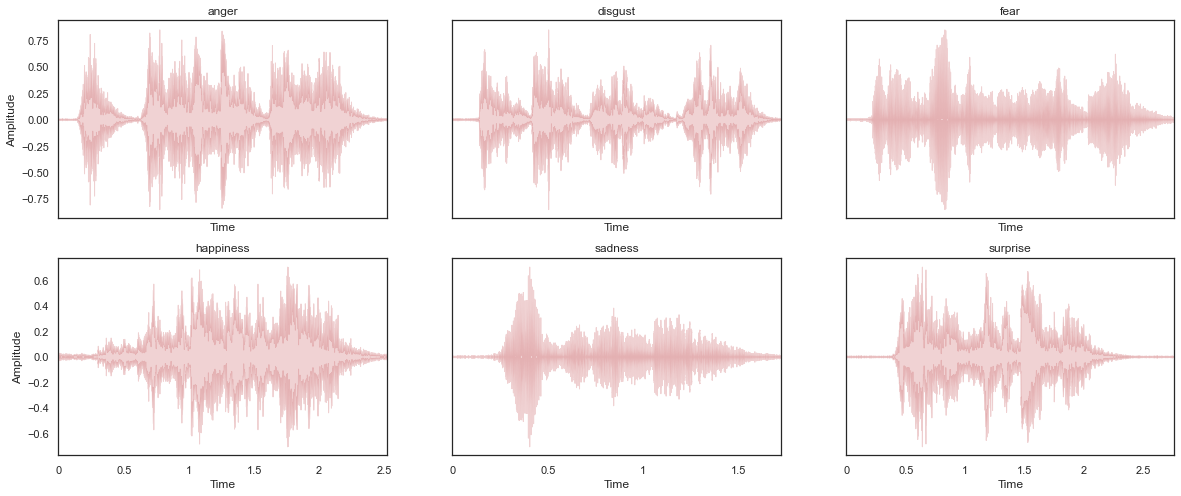

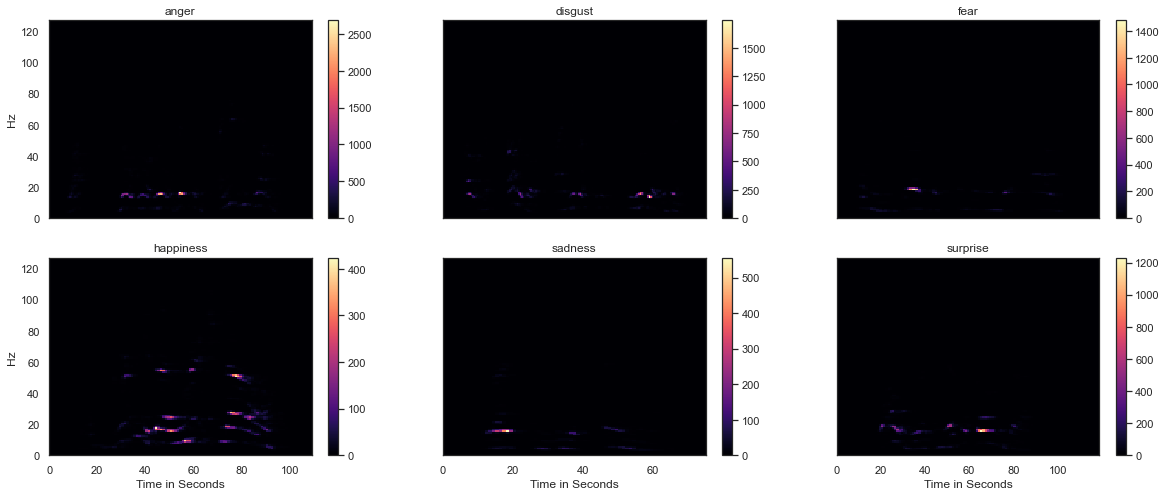

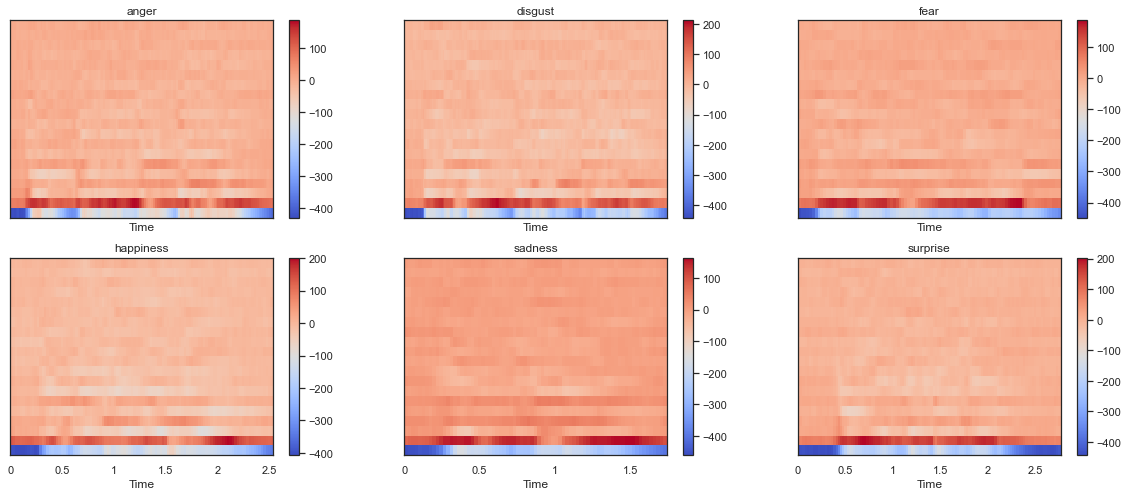

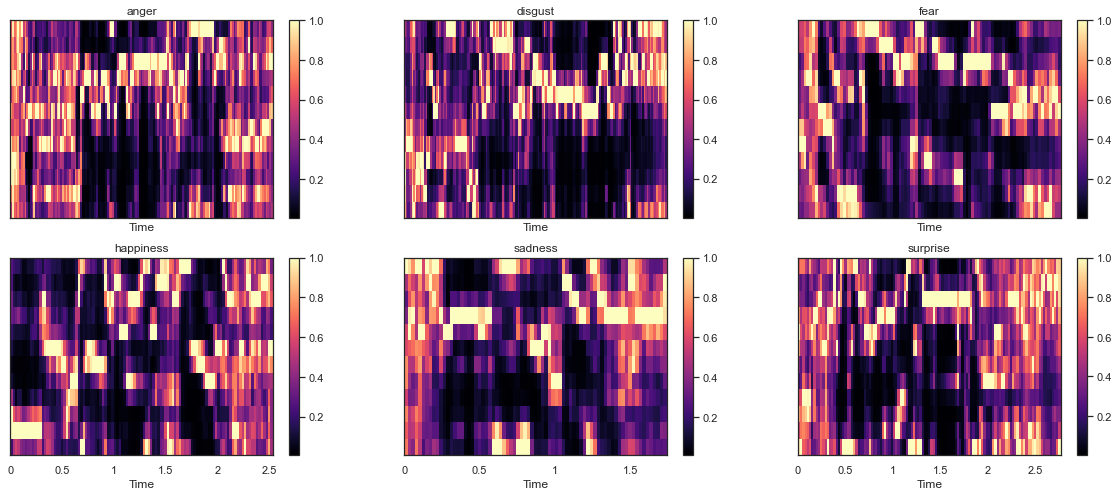

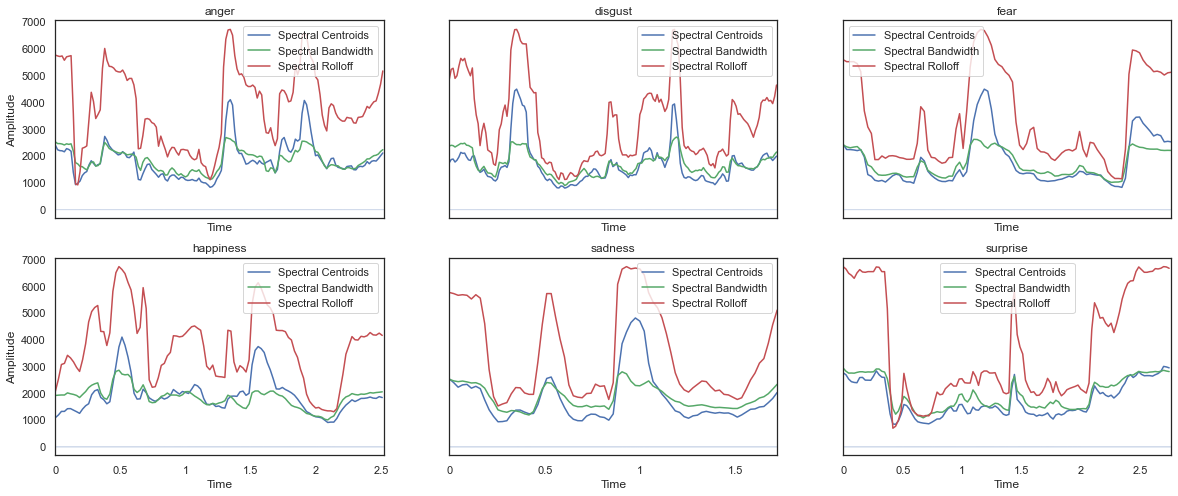

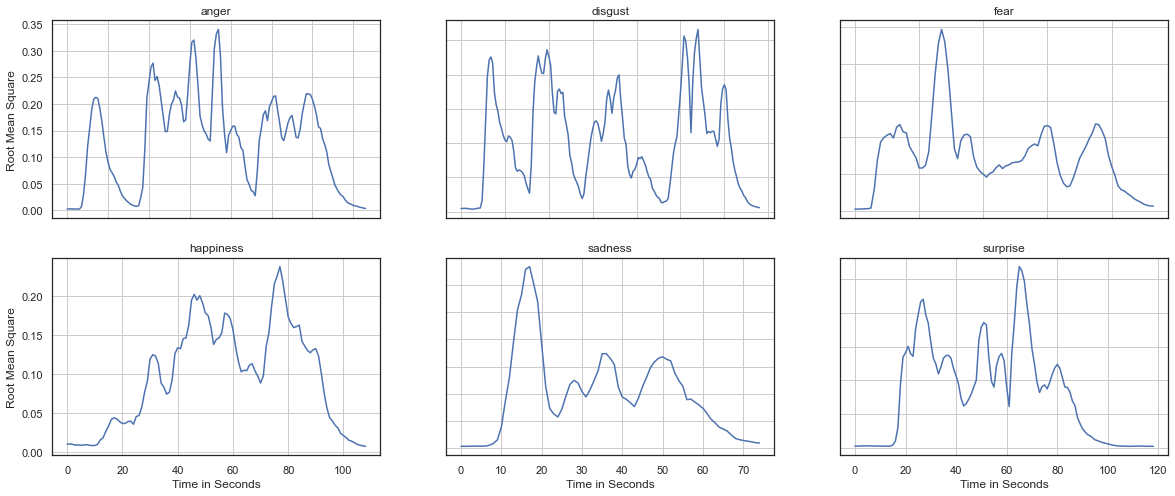

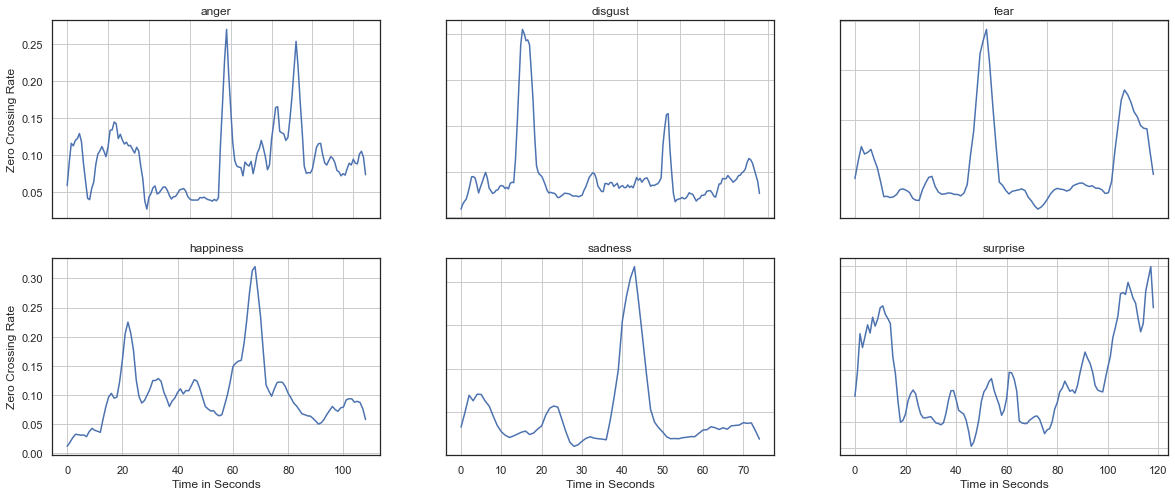

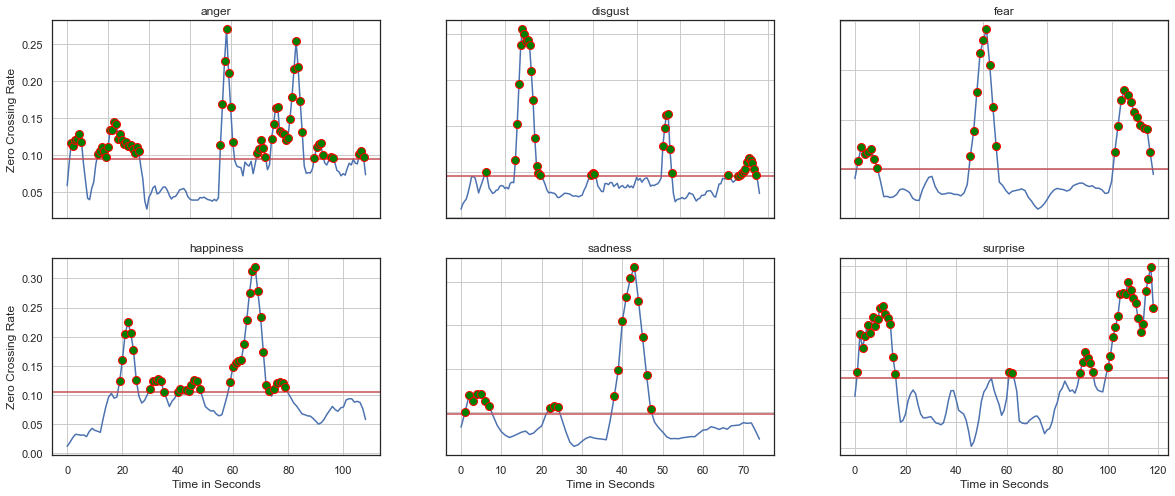

In [85]:
subj_1_sent_1 = df.loc[df['File'].str.contains(r's1_([a-z]*)_1', regex = True)]

audio_analysis(subj_1_sent_1)

# Single Feature Analysis

In [91]:
sns.set_theme(style="white")
colors = ['b', 'g', 'r', 'y', 'k', 'm', 'c', 'w']

def analyse_feature(df, feature, gender):
    grid = plt.GridSpec(6, 1, wspace=.1, hspace=.3)
    fig = plt.figure(figsize=(18, 28), tight_layout=True)
    # fig.suptitle(f"{feature} Analysis, 5 Subjects ({gender}), 1 Sentence", y=0.90, fontsize=18)
    emotions = {'an': 'anger', 'ha': 'happiness', 'sa': 'sadness', 'di': 'disgust', 'fe': 'fear', 'su': 'surprise'}
    threshold = 0.04

    for i, emotion in enumerate(emotions):
        subjs_data = df.loc[df['File'].str.contains(f"s*_{emotion}_1", regex = True) & df['Gender'].str.contains(gender)][:5]
        ax = plt.subplot(grid[i, :])
        ax.set_title(emotions[emotion])

        for i, data in enumerate(subjs_data.iterrows()):
            subj, data = data
            color = colors[i]
            zcr = np.array(data[feature])
            num_spikes = spikes(zcr)
            mean = np.mean(zcr)
            sum = np.sum(zcr)
            var = np.var(zcr)
            std = np.std(zcr)
            label = f"Subject {subj}, Mean: {mean:.03f}, Var: {var:.03f}, Std: {std:.03f}, Spikes: {num_spikes}, Sum: {sum:.03f}"
            zcr = np.concatenate(zcr)
            x = np.arange(len(zcr))
            ax.set(xlabel="Time in Seconds", ylabel="Zero Crossing Rate")
            ax.plot(zcr, f'{color}-', label=label)
            ax.fill_between(x, zcr + threshold, zcr - threshold, color=color, alpha=0.2)
        ax.legend()

    plt.show()

In [88]:
def analyse_feature_same_subject(df, feature, gender):
    subject = "s1" if gender == "m" else "s4"
    grid = plt.GridSpec(1, 1, wspace=.1, hspace=.4)
    fig = plt.figure(figsize=(16,5), tight_layout=True)
    # fig.suptitle(f"{feature} Analysis, 1 Subject ({gender}), 5 Sentence", fontsize=18)
    threshold = 0.04

    subj_data = df.loc[df['File'].str.contains(f"{subject}_[a-z]*_1", regex = True)]
    ax = plt.subplot(grid[0, :])
    for i, data in enumerate(subj_data.iterrows()):
        subj, data = data
        color = colors[i]
        zcr = np.array(data[feature])
        num_spikes = spikes(zcr)
        mean = np.mean(zcr)
        sum = np.sum(zcr)
        var = np.var(zcr)
        std = np.std(zcr)
        label = f"Emotion: {data['Emotion']}, Mean: {mean:.03f}, Var: {var:.03f}, Std: {std:.03f}, Spikes: {num_spikes}, Sum: {sum:.03f}"
        zcr = np.concatenate(zcr)
        x = np.arange(len(zcr))
        ax.plot(zcr, f'{color}-', label=label)
        ax.set(xlabel="Time in Seconds", ylabel="Zero Crossing Rate")
        ax.fill_between(x, zcr + threshold, zcr - threshold, color=color, alpha=0.2)
    ax.legend()

    plt.show()

## Zero Crossing Rate Analysis

### For each Emotion take 1 Sentence of 5 Male Subjects
#### Feature Unnormalized

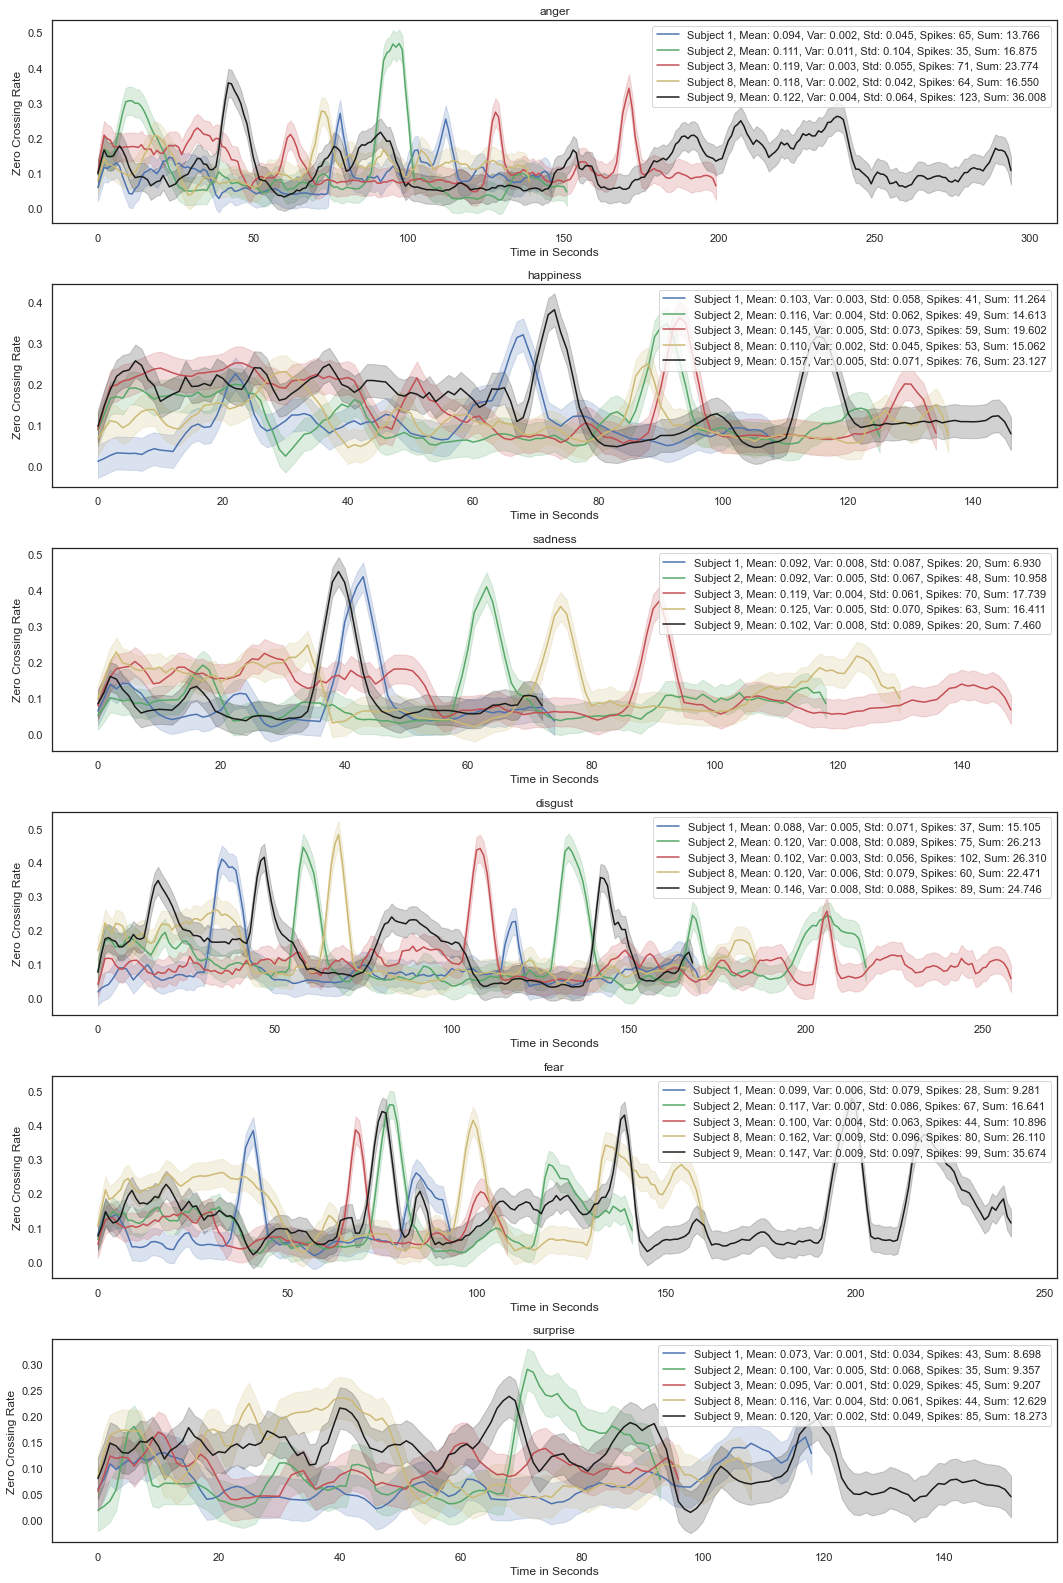

In [92]:
analyse_feature(df, 'zcr', 'm')

### For each Emotion take 1 Sentence of 5 Female Subjects

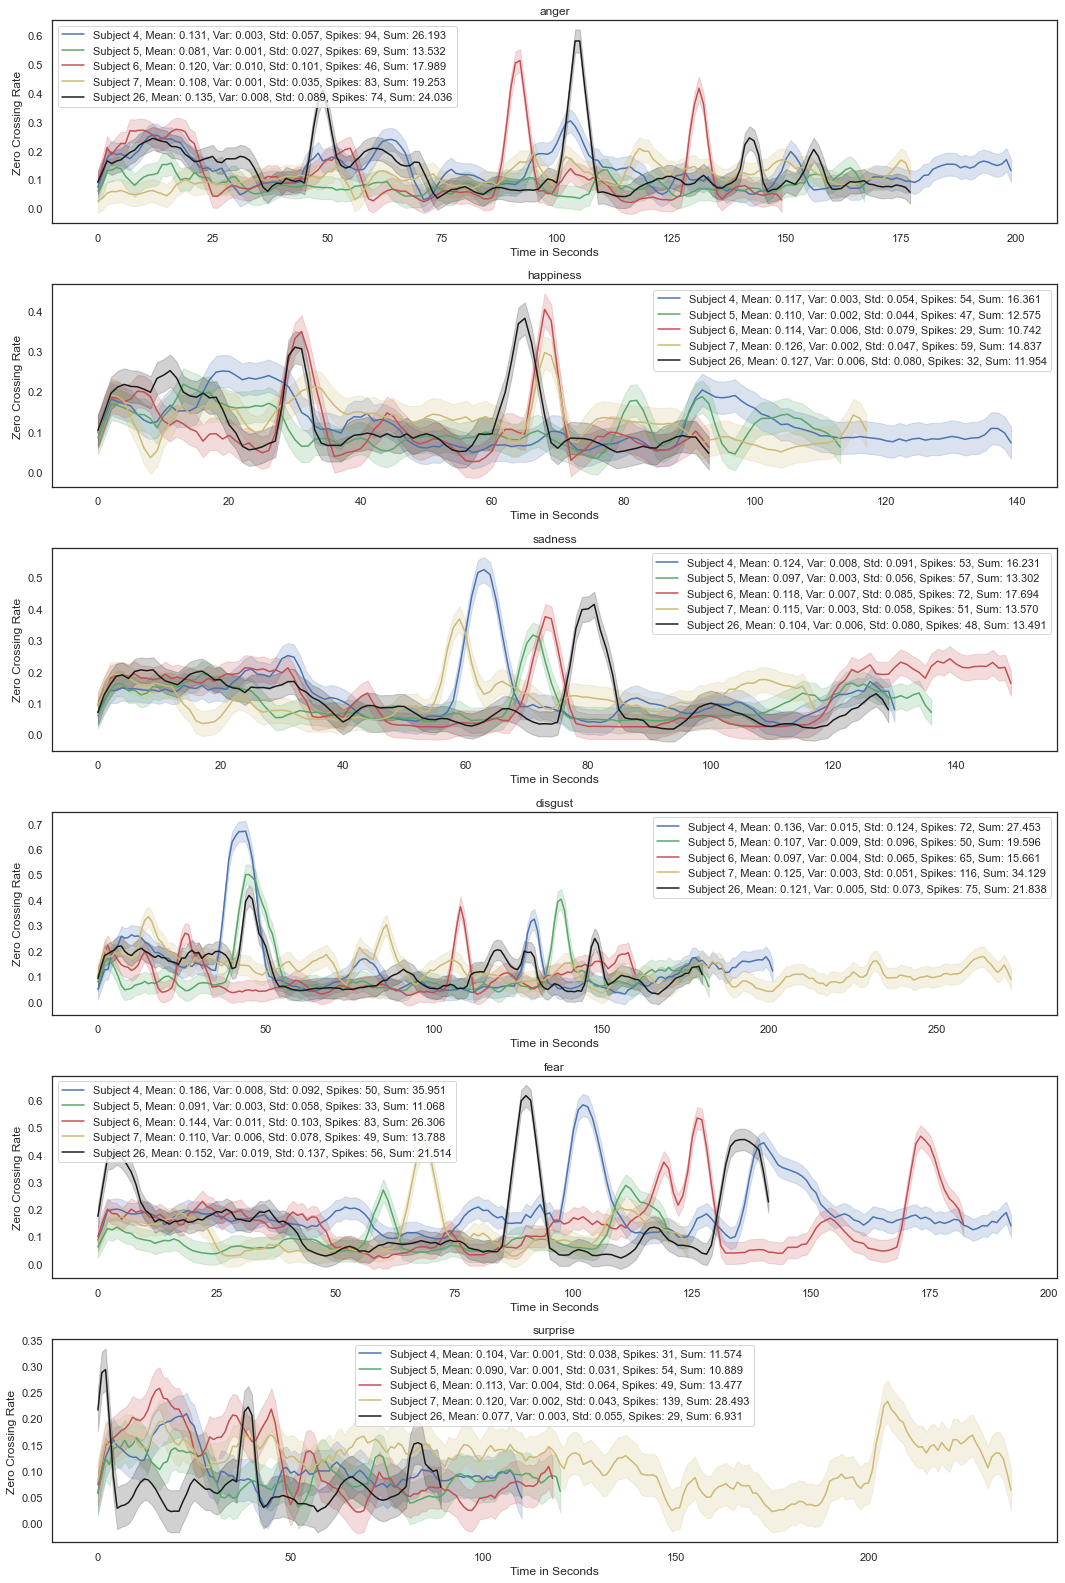

In [93]:
analyse_feature(df, 'zcr', 'f')

### For each Emotion take 5 Sentences of 1 Male Subject

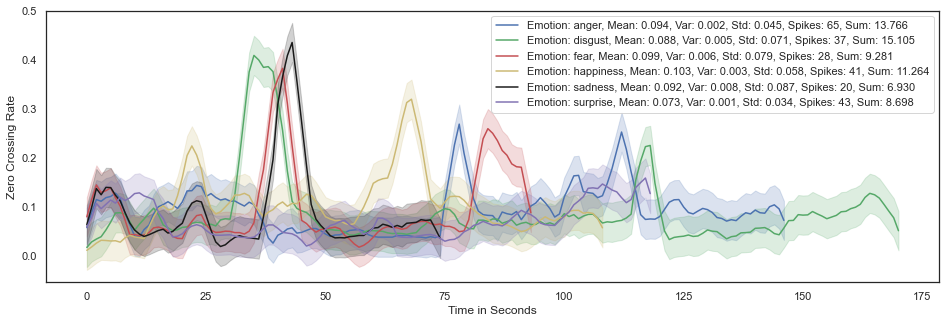

In [82]:
analyse_feature_same_subject(df, 'zcr', 'm')

### For each Emotion take 5 Sentences of 1 Female Subject

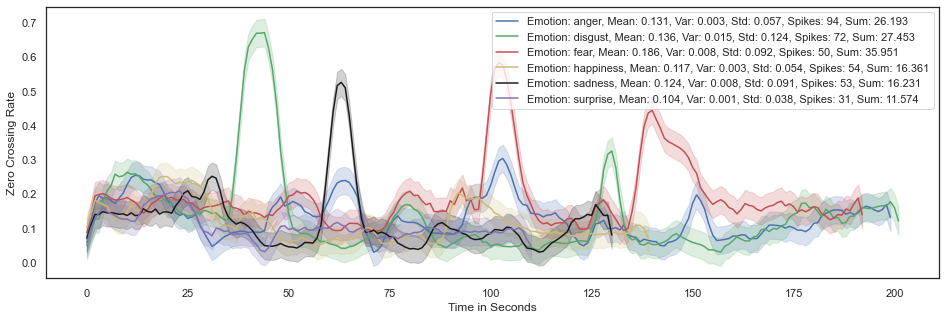

In [83]:
analyse_feature_same_subject(df, 'zcr', 'f')